[View in Colaboratory](https://colab.research.google.com/github/gmihaila/deep_learning_toolbox/blob/master/text_sum_no_generator.ipynb)

## Download Data

link for data: http://research.signalmedia.co/newsir16/signalmedia-1m.jsonl.gz

In [0]:
!wget http://research.signalmedia.co/newsir16/signalmedia-1m.jsonl.gz


print("\nFinished!")

--2018-05-28 15:52:22--  http://research.signalmedia.co/newsir16/signalmedia-1m.jsonl.gz
Resolving research.signalmedia.co (research.signalmedia.co)... 52.218.105.28
Connecting to research.signalmedia.co (research.signalmedia.co)|52.218.105.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1066404716 (1017M) [application/x-gzip]
Saving to: ‘signalmedia-1m.jsonl.gz’

signalmedia-1m.json  87%[================>   ] 890.29M  25.7MB/s    eta 8s     

signalmedia-1m.json 100%[===================>]   1017M  29.7MB/s    in 53s     

2018-05-28 15:53:16 (19.0 MB/s) - ‘signalmedia-1m.jsonl.gz’ saved [1066404716/1066404716]


Finished!


## Parse json and create indexes

### Imports

In [0]:
!pip install gensim
!apt-get -qq install -y graphviz && pip install -q pydot

In [1]:
import os
import sys
import json
import gzip
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import callbacks

from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Input
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint


import numpy as np
import cPickle as pickle

import gensim
from gensim.models import KeyedVectors

from unicodedata import normalize

import pydot
from IPython.display import Image

import matplotlib.pyplot as plt

from nltk.translate.bleu_score import corpus_bleu

import random



Using TensorFlow backend.


### Functions

In [0]:
# clean text strings
def CleanText(text):
  # normalize unicode characters
#   junk_words = ['\r', '\t', '-', '/', '!','"','#','$','%','&','(',')','*', '+']
  junk_words = list(string.punctuation) + ['\r', '\t', 'ht', '2']
  text = normalize('NFD', text).encode('ascii', 'ignore')
  text.replace('\r', '')
  
  # split a loaded document into sentences
  text = text.strip().split('\n')
  text = " ".join([line for line in text])
  
  # remove junk words
  for junk_word in junk_words:
    text = text.translate(None, junk_word)
  # lower case
  text = text.lower()
  # split on white space
  text = text.split(' ')
  # remove null strings
  text = filter(None, text)
  text = [word for word in text if len(word)< 25]
  return text


# fit a tokenizer
def MyTokenizer(data, n_words):
  # fit tokenizer
  tokenizer = Tokenizer(num_words=n_words+1, filters=string.punctuation, lower=True, split=' ', char_level=False, oov_token='<unk>')
  # feed each sequence
  [tokenizer.fit_on_texts([x[0]+x[1]]) for x in data]
  
  tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= n_words}
  tokenizer.word_index[tokenizer.oov_token] = n_words + 1

  return tokenizer


# encode and pad sequences
def EncSeq(data, tokenizer, n_words, n_input, n_output, start_f=False, end_f=False):
  # input and output
  x, y = [], []
  s_flag, e_flag = 0, 0
  
  if start_f:
    s_flag = 1
  if end_f:
    e_flag = 1
    
  for content,title in data:
    sequence = tokenizer.texts_to_sequences([content])
    x.append(sequence[0])
    
    sequence = tokenizer.texts_to_sequences([title])
    y.append([n_words+2] * s_flag + sequence[0] + [n_words+2] * e_flag)
    del sequence
    
  x = pad_sequences(x, maxlen=n_input, padding='post')
  y = pad_sequences(y, maxlen=(n_output + s_flag + e_flag), padding='post')
  
  return x,y


# one hot encode target sequence
def EncOutput(sequences, n_words):
  output = []
  for sequence in sequences:
    seq_output = []
    
    for index in sequence:
      encoded = to_categorical(index, num_classes=n_words+3).astype(int)
      seq_output.append(encoded)
      
    output.append(seq_output)
    
  return np.array(output)


# index word dictionary
def IndexWord(tokenizer):
  index_word = {}
  for word, index in tokenizer.word_index.items():
    index_word[index] = word
    
  return index_word

# define model
def define_model(n_words, n_input, n_output, n_units):
  model = Sequential()
  model.add(Embedding(input_dim=(n_words + 2), output_dim=n_embed, input_length=n_input, mask_zero=True, name='EMBEDDING'))
  model.add(LSTM(units=n_units, dropout=0.0, recurrent_dropout=0.0,return_sequences=False, return_state=False, name='ENCODER_LSTM'))
  model.add(RepeatVector(n=n_output, name='REPEAT_VECT'))
  model.add(LSTM(units=n_units, dropout=0.0, recurrent_dropout=0.0,return_sequences=True, return_state=False, name='DECODER_LSTM'))
  model.add(TimeDistributed(Dense(units=(n_words + 3), activation='softmax', name='DECODER_OUT')))
  
  return model


# generate target given source sequence
def Predictions(model, test_data, index_word):
  pred_sequence = model.predict(test_data, verbose=0)
  word_predictions = []
  for sequence in pred_sequence:
    word_seq = []
    for prediction in sequence:
      index = np.argmax(prediction)
      word_seq.append(index_word[index])
    word_predictions.append(word_seq)  

  return word_predictions




### Parse Data

In [3]:
dataset = []    # whole data

n_input = 10    # number of tokens of article
n_output = 5    # number of tokens in headline

n_articles = 100# number of articles (data length)

n_words = 20    # number of top most frequent words to use

# open zip and start reading
with gzip.open("signalmedia-1m.jsonl.gz", "rb") as f:
  print ('Open JSON to read...\n')
  
  for index, line in enumerate(f):
    
    if (index+1)%100000 == 0:
      print('Another 100,000 articles.\n')
      
    # convert from JSON
    entry = json.loads(line.decode("ascii"))
    
    ID = entry['id']
    content = entry['content']
    title = entry['title']
    media = entry['media-type']
    source = entry['source']
    published = entry['published']
    
    # clear entry variable
    del entry
    
    # clean data
    content = CleanText(content)
    title = CleanText(title)
    
    # append data
    dataset.append([content[:n_input], title[:n_output]])
    
    # clean memory
    del content, title, media, source, published
    
    if index+1 == n_articles:
      break
    
print('Dataset: %s'%len(dataset))
print ('Articles: %s'%n_articles)
  
print ('\nFinsihed!')


Open JSON to read...

Dataset: 100
Articles: 100

Finsihed!


## Tokenizing Data

In [5]:
# random shuffle
np.random.shuffle(dataset)

# split into train/test
train_data, test_data = dataset[:9], dataset[9:]
print('Train size: %s'%len(train_data))
print('Test size: %s'%len(test_data))

# create the tokenizer for words
tokenizer = MyTokenizer(data=dataset, n_words=n_words)

# create training sequences
x_train, y_train = EncSeq(data=train_data, tokenizer=tokenizer, n_words=n_words, n_input=n_input, n_output=n_output, start_f=False, end_f=False)
y_train = EncOutput(sequences=y_train, n_words=n_words)

# create testing sequences
x_test, y_test = EncSeq(data=test_data, tokenizer=tokenizer, n_words=n_words, n_input=n_input, n_output=n_output, start_f=False, end_f=False)
y_test = [data[1] for data in test_data]




Train size: 9
Test size: 91


### Model

In [0]:
# parameters
n_embed = 32
enc_lstm = 1
n_units = 32
n_epochs = 2
n_batch = 32

# define model
model = define_model(n_words=n_words, n_input=n_input, n_output=n_output, n_units=n_units)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# summarize defined model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING (Embedding)        (None, 10, 32)            704       
_________________________________________________________________
ENCODER_LSTM (LSTM)          (None, 32)                8320      
_________________________________________________________________
REPEAT_VECT (RepeatVector)   (None, 5, 32)             0         
_________________________________________________________________
DECODER_LSTM (LSTM)          (None, 5, 32)             8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 23)             759       
Total params: 18,103
Trainable params: 18,103
Non-trainable params: 0
_________________________________________________________________
None


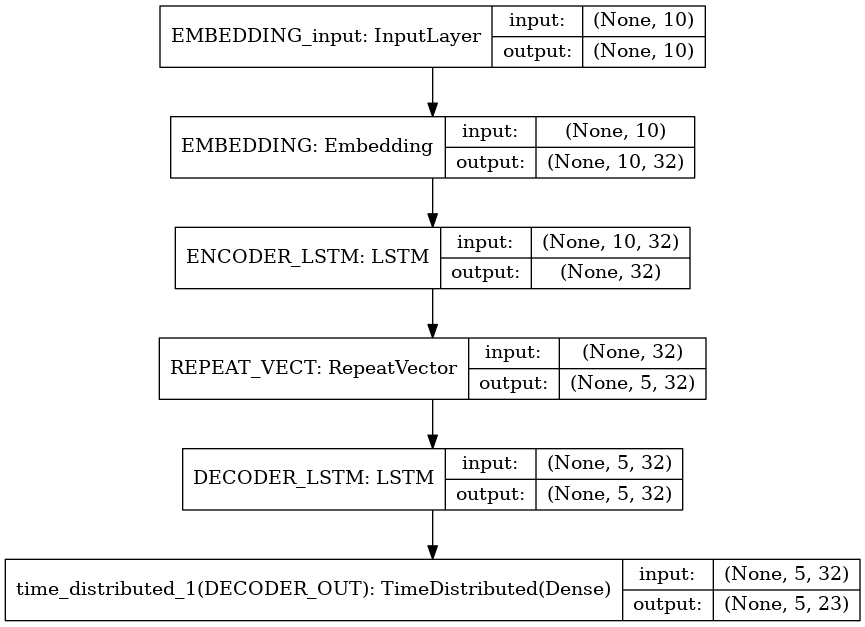

In [10]:
# plot model
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [22]:
# train with checkpoints
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, callbacks=[checkpoint], verbose=2)

Train on 7 samples, validate on 2 samples
Epoch 1/2
 - 1s - loss: 3.1432 - acc: 0.0286 - val_loss: 3.1373 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 3.13730, saving model to model.h5
Epoch 2/2
 - 0s - loss: 3.1377 - acc: 0.0286 - val_loss: 3.1320 - val_acc: 0.3000

Epoch 00002: val_loss improved from 3.13730 to 3.13200, saving model to model.h5


In [0]:
# save model
model.save('final_model.h5')

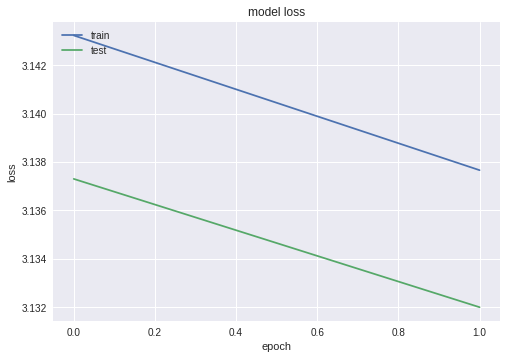

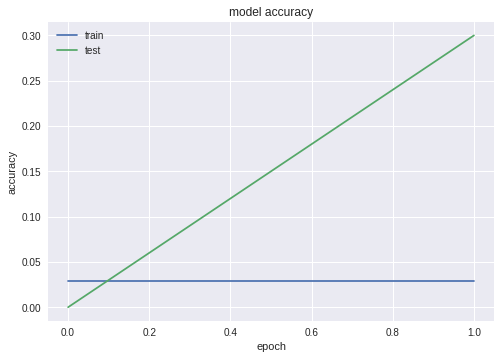

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

In [24]:
# evaluate on BLEU score
index_word = IndexWord(tokenizer)

y_hat = Predictions(model=model, test_data=x_test, index_word=index_word)

print('BLEU-1: %f' % corpus_bleu(y_test, y_hat, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(y_test, y_hat, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(y_test, y_hat, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(y_test, y_hat, weights=(0.25, 0.25, 0.25, 0.25)))
print('')

for index in range(1):
  print('Original:\t%s'%y_test[index])
  print('----------')
  print('Predicted:\t%s\n\n'%y_hat[index])
  

BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000

Original:	['police', 'ciefs', 'warn', 'minisers', 'were']
----------
Predicted:	['<unk>', '<unk>', '<unk>', '015', 'for']




### Word Embeddings - Not implemented yet.
For now is creating its own embeddings for words while it trains.
I will implement the pre-set word embeddings

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
  
!gunzip GoogleNews-vectors-negative300.bin.gz

!ls

--2018-05-28 04:16:37--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.225.107
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.225.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

300.bin.gz           93%[=================>  ]   1.44G  46.9MB/s    eta 4s     

GoogleNews-vectors- 100%[===================>]   1.53G  47.0MB/s    in 47s     

2018-05-28 04:17:25 (33.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

_about.txt		 english-german-train.pkl
datalab			 final_model.h5
deu-eng.zip		 GoogleNews-vectors-negative300.bin
deu.txt			 model.h5
english-german-both.pkl  model.png
english-german.pkl	 signalmedia-1m.jsonl.gz
english-german-test.pkl


In [0]:
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [0]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

In [0]:
model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)
